# Transmon v5

This is the updated version which allows for the fact that gates can be decomposed using the vZX basis. If the fidelity turns out to not be easily transferrable to generalised gates, use the XY basis?

## basis

A gate $U(\theta,\phi, \lambda)$ is deconstructed into

$$Z(φ-π/2) @ X(π/2) @ Z(π-θ) @ X(π/2) @ Z(λ-π/2)$$

note the $@$ means matrix multiplication: this is the symbol used by numpy

note $\theta=0$ means the gate is just a z rotation of $\phi+\lambda$

## phase change

to implement a virtual Z gate, just change the phase of the sinusoides of all the following gates by that amount (not sure if positive or negative)

for example, a Z45 gate is implemented by adding (or subtracting) a phase of pi/4 to the sinusoid of all the next gates.

## key problem

there are a few key issues I need to work on

- the pulse for moving $\ket{0}\to\ket{+}$ for example (Y90) doesn't leave a state on the Y-axis unchanged. this implies that there is some issue with the optimisation or hamiltonian itself somewhere. should I move to the rotating frame? how exactly does the drive couple?
- once that is done, the workflow should be as follows:
  1. define the transmon parameters
  2. define a circuit, which may be one gate
  3. create a time series, such that each gate corresponds to TWO Xpi/2 pulses, and three virtual Z gates as above
  4. when implementing the pulse, add a phase to each Xpi/2 pulse corresponding to the cumulative phase built up by the Z rotations
  5. note this must be a piecewise function, as mesolve doesn't take np arrays in the hamiltonian - only callback functions
  6. return the final state

as a result, ONLY the Xpi/2 pulse needs to be optimised. you need to check that it actually implements this rotation no matter where it starts. importantly, you need to check that implementing an Xpi/2 rotation with a phase in the sinusoid corresponds to implementing the expected rotation. make sure adding the phase makes the qubit behave as expected.

## derivation of phase gate

for all systems,

$$H_0=\sum_j{\hbar \omega_j\ket{j}\bra{j}}$$

and

$$\ket{\psi(t)}=\sum_j{c_j(t)\ket{j}}$$

for a two-level system, if

$$\ket{\psi(0)}=\alpha\ket{0}+\beta\ket{1}$$

we have

$$\ket{\psi(t)}=\alpha e^{-\frac{\imath E_0 t}{\hbar}}\ket{0}+\beta e^{-\frac{\imath E_1 t}{\hbar}}\ket{1}$$

on the bloch sphere, the overall phase can be discarded, so the phase angle $\phi$ on the Bloch sphere is

$$\phi(t)=\frac{E_0-E_1}{\hbar}t$$

meaning that to enact a phase gate of $Z(\phi)$ (anticlockwise around $z$), wait a time

$$t=\frac{2\pi-\phi}{\omega_{12}}$$

however, decoherence and decay means waiting this time is not good for fidelity

therefore, we instead simply redefine the axes

how should this be implemented?

In [1]:
# import

import numpy as np
from qutip import basis, Bloch, destroy, Qobj
from qutip_qip import circuit, operations
import matplotlib.pyplot as plt

%matplotlib qt

In [2]:
# the tuples are (θ, φ, λ)

π = np.pi

gate_angles = {
    "X180" : (π, 0, 0),
    "Y180" : (π, π/2, -π/2),
    "Z180" : (0, π/2, π/2),
    "X90" : (π/2, 0, 0),
    "Y90" : (π/2, π/2, -π/2),
    "S" : (0, π/4, π/4),
    "H" : (π/2, π/2, π/2),
    "X45" : (π/4, 0, 0),
    "T" : (0, π/8, π/8)
}

In [3]:
# set up a transmon

class Transmon:

    def __init__(self, n_levels:int, initial_level:int, Ω:float=5000, α:float=-350, t_decay:float=np.inf, t_dephase:float=np.inf):
        
        self.n_levels = n_levels
        self.Ω = Ω
        self.α = α
        self.t_decay = t_decay
        self.t_dephase = t_dephase

        self.ψ0 = basis(n_levels, initial_level)

        a = destroy(n_levels)
        n = a.dag() * a

        self.e_ops = [basis(n_levels, i) * basis(n_levels, i).dag() for i in range(n_levels)]
        self.c_ops = [np.sqrt(1/t_decay) * a, np.sqrt(1/t_dephase) * a.dag()*a]

        Ec = -α
        Ej = (-1*(Ω-α)**2)/(8*α)

        # with RWA
        self.H0 = Ω*n + 0.5*α*n*(n-1)    
        
        # without RWA
        # decrease timesteps for more accurate analysis
        # self.H0 = -4*Ec*np.sqrt(Ej/(32*Ec)) * (a.dag()-a)**2 + Qobj(-Ej*np.cos(((2*Ec)/Ej)**0.25 * (a.dag()+a).full()))

        self.H1 = a + a.dag()

In [4]:
# to simulate this, just do the two X gates with the appropriate phase shifts

class Gate:

    def __init__(self, name=None, angles=None):
        # angles is of the form (θ, φ, λ)

        if name is not None:
            try:
                self.name = name
                self.angles = gate_angles[name]
            except KeyError:
                return "Error: this gate is not recognised."
        elif angles is None:
            raise ValueError("Either name or angles must be specified.")
        else:
            self.name="custom"
            self.angles = angles
        
        θ, φ, λ = self.angles

        self.full = np.array(
        [
            [np.cos(θ/2), -1j*np.exp(1j*λ)*np.sin(θ/2)], 
            [-1j*np.exp(1j*φ)*np.sin(θ/2), np.exp(1j*(φ+λ))*np.cos(θ/2)]
            ]
        )

In [5]:
def calculate_target_state(initial_state, gate, plot=False):

    # initial_state is a Qobj
    # gate is an instance of Gate

    def custom_gate():
        return Qobj(gate.full, dims=[[2], [2]])

    qc1 = circuit.QubitCircuit(1) 
    qc1.user_gates = {"custom":custom_gate}
    qc1.add_gate("custom", 0)
    result = qc1.run(initial_state)

    if plot:
        b = Bloch()
        b.make_sphere()
        b.add_states(result)
        b.render()
        b.show()
        plt.show()

    return result

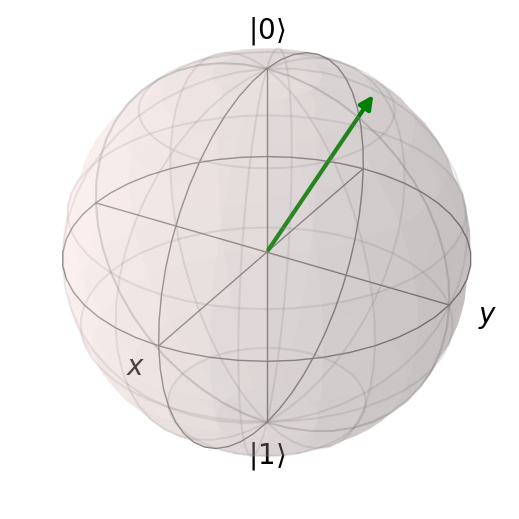

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.80178373+0.53452248j]
 [ 0.        -0.26726124j]]

In [7]:
initial = (basis(2,0) - (3j+2)*basis(2,1)).unit()
g= Gate(angles=gate_angles["X180"])

calculate_target_state(initial, g, plot=True)